# Introduction

This notebook illustrates a parametrized classifier trained on a Gaussian example with a two-dimensional (spherical) family of parameters.

It will cover how to:

- train a classifier to distinguish between samples drawn from the "background" Gaussian distribution, $\mathcal{N}\left(\left[\begin{matrix}0 \\ 0 \end{matrix}\right], \left[\begin{matrix}1 & 0\\0 & 1 \end{matrix}\right]\right)$ and the "signal" Gaussian distribution, $\mathcal{N}\left(\left[\begin{matrix}\mu(\theta,\phi) \\ 0 \end{matrix}\right], \left[\begin{matrix}\nu_1(\theta,\phi) & 0\\0 & \nu_2(\theta,\phi) \end{matrix}\right]\right) = \mathcal{N}\left(\left[\begin{matrix} \frac{1-\cos\phi}{2} \\ 0 \end{matrix}\right], \left[\begin{matrix} \frac{2-\cos\theta\sin\phi}{2} & 0\\0 & \frac{2-\sin\theta\sin\phi}{2} \end{matrix}\right]\right)$ 

- use a parametried classifier to infer what pair ($\theta, \phi$) a sample was created with. 

## Imports

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('..', '..')))

In [2]:
import numpy as np
import datetime
import sklearn.metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scipy.stats import chi
from scipy import stats
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
import utils
from utils.functions import mean_gen, varx_gen, vary_gen, spherical_data, test_on_integers, discrete_angles
from utils.functions import learn_parameters, likelihood_ratio, compare_learning, compare_learning_thorough
from tensorflow.python.framework.ops import disable_eager_execution
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# Building the interpolated model through sampling the parameter sphere

## Generating Data

In [3]:
n = 200000

n_th = 50 # number of discrete random thetas to sample in range (0, 2 * pi)
n_ph = 50 # number of discrete random phis to sample in range (0, pi)
thetas = discrete_angles(n, n_th, 2)
phis = discrete_angles(n, n_ph, 1)
name = ('discrete_model_mth%.0f_mph%.0f' %(n_th, n_ph))

x_train, x_test, y_train, y_test = spherical_data(n, thetas, phis)

## Training Interpolated Model

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
]);

loss_fn = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

batch_size = 5000

checkpoint_path = "checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1,
    save_freq=10*batch_size
)

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

EPOCHS=30
model.fit(
    x_train, y_train, epochs=EPOCHS,
    batch_size=batch_size,
    callbacks=[cp_callback, tensorboard_callback]
);

model.save('3dmodels/' + name)

Epoch 1/30


2022-10-12 14:03:13.025578: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


64/64 [==============================] - 1s 7ms/step - loss: 0.6608 - accuracy: 0.5933
Epoch 2/30
64/64 [==============================] - 0s 6ms/step - loss: 0.6480 - accuracy: 0.6098
Epoch 3/30
64/64 [==============================] - 0s 7ms/step - loss: 0.6456 - accuracy: 0.6122
Epoch 4/30
64/64 [==============================] - 0s 6ms/step - loss: 0.6442 - accuracy: 0.6137
Epoch 5/30
64/64 [==============================] - 0s 6ms/step - loss: 0.6431 - accuracy: 0.6150
Epoch 6/30
64/64 [==============================] - 0s 6ms/step - loss: 0.6423 - accuracy: 0.6153
Epoch 7/30
64/64 [==============================] - 0s 6ms/step - loss: 0.6415 - accuracy: 0.6164
Epoch 8/30
64/64 [==============================] - 0s 6ms/step - loss: 0.6410 - accuracy: 0.6171
Epoch 9/30
64/64 [==============================] - 0s 6ms/step - loss: 0.6404 - accuracy: 0.6176
Epoch 10/30
64/64 [==============================] - 0s 6ms/step - loss: 0.6402 - accuracy: 0.6174
Epoch 11/30
64/64 [===========

# Learning a single point $(\theta, \phi)$ on the parameter sphere from data

## Generating Data

In [5]:
# Generate Data from a single point on the parameter sphere
seed = 44444
n = 10000
theta = 2.45
phi = 1.21
thetas, phis = theta * np.ones(n), phi * np.ones(n)
x_train, x_test, y_train, y_test = spherical_data(n, thetas, phis, seed)
x_inputs = x_train[:, 0:2]

# Likelihood Ratio of Data
l_out = likelihood_ratio(x_train)

## Build Likelihood Model Parameter-Finder (for benchmark)

In [6]:
# Kernel Initializer
s = tf.convert_to_tensor([1.]).shape
res = tf.random.uniform(s, maxval=2*np.pi, seed=seed), tf.random.uniform(s, maxval=np.pi, seed=seed)
def my_init(shape, dtype=None):
    return tf.transpose(tf.convert_to_tensor(res))

# Likelihood Model

loss_fn0 = tf.keras.losses.BinaryCrossentropy()

# Building model_angles which is used to train (theta, phi)
inputs_hold0 = tf.keras.Input(shape=(1,))
simple_linear0 = Dense(2, use_bias = False, kernel_initializer=my_init)(inputs_hold0)
model_angles0 = Model(inputs = inputs_hold0, outputs = simple_linear0)

# Building model_parmafinder, inputs, which takes the (x, y) and finds the best (theta, phi)
raw_inputs0 = tf.keras.Input(shape=(2,))
inputs0 = tf.keras.layers.concatenate([raw_inputs0, model_angles0(tf.ones_like(raw_inputs0)[:,0:1])])
output0 = likelihood_ratio(inputs0)

model_likelihood_paramfinder = Model(inputs = raw_inputs0, outputs = output0)
model_likelihood_paramfinder.compile(loss=loss_fn0, optimizer='Adam')

## Build Interpolated Model Parameter-Finder

In [7]:
# Loading Previously Trained Interpolated Model 
model_interpolate = tf.keras.models.load_model('3dmodels/discrete_model_mth50_mph50')
for l in model_interpolate.layers:
    l.trainable=False
    
loss_fn = tf.keras.losses.BinaryCrossentropy()

# Building model_angles which is used to train (theta, phi)
inputs_hold = tf.keras.Input(shape=(1,))
simple_linear = Dense(2, use_bias = False, kernel_initializer=my_init)(inputs_hold)
model_angles = Model(inputs = inputs_hold, outputs = simple_linear)

# Building model_parmafinder, inputs, which takes the (x, y) and finds the best (theta, phi)
raw_inputs = tf.keras.Input(shape=(2,))
inputs = tf.keras.layers.concatenate([raw_inputs, model_angles(tf.ones_like(raw_inputs)[:,0:1])])
output = model_interpolate(inputs)

model_interpolate_paramfinder = Model(inputs = raw_inputs, outputs = output)
model_interpolate_paramfinder.compile(loss=loss_fn, optimizer='Adam')

## Train and Compare Models

Initialized at  tf.Tensor([1.2422765 2.10618  ], shape=(2,), dtype=float32) tf.Tensor([1.2422765 2.10618  ], shape=(2,), dtype=float32)
54/54 [==============================] - 0s 1ms/step - loss: 0.7265
0 Fitted result 1:  tf.Tensor([1.29396   2.0558114], shape=(2,), dtype=float32)
0 Fitted result 2:  tf.Tensor([1.2942629 2.0533679], shape=(2,), dtype=float32)
54/54 [==============================] - 0s 1ms/step - loss: 0.7195
1 Fitted result 1:  tf.Tensor([1.3421074 2.0075798], shape=(2,), dtype=float32)
1 Fitted result 2:  tf.Tensor([1.3437978 2.0028067], shape=(2,), dtype=float32)
54/54 [==============================] - 0s 1ms/step - loss: 0.7119
2 Fitted result 1:  tf.Tensor([1.3883721 1.9598764], shape=(2,), dtype=float32)
2 Fitted result 2:  tf.Tensor([1.3918152 1.9543165], shape=(2,), dtype=float32)
54/54 [==============================] - 0s 1ms/step - loss: 0.7064
3 Fitted result 1:  tf.Tensor([1.4318476 1.9144993], shape=(2,), dtype=float32)
3 Fitted result 2:  tf.Tensor([1

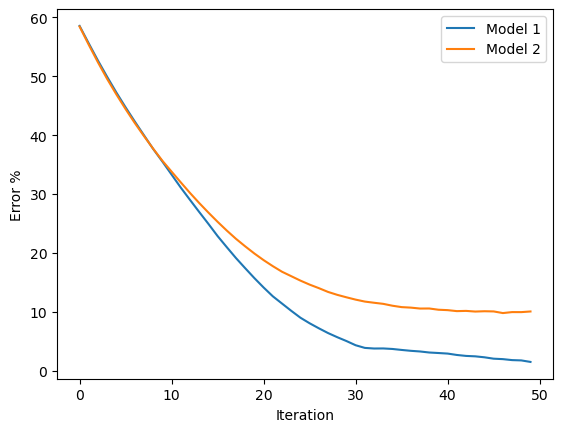

In [8]:
epochs, iterations, batch_size = 1, 50, 300

# # Likelihood Stats
# weights0 = learn_parameters(model_paramfinder, x_train, y_train, iterations, epochs, batch_size)
# angle_errors0 = (angles - weights0) / angles
# average_error0 = np.sum(np.abs(angle_errors0)) / 2


# Comparing
angles = np.array([theta, phi])
list_mlp, list_mip = compare_learning(model_likelihood_paramfinder, model_interpolate_paramfinder, angles,
                                      x_train, y_train, iterations, epochs, batch_size)

## Validation

In [29]:
print(mean_gen(theta, phi))
print(varx_gen(theta, phi))
print(vary_gen(theta, phi))
lz = mean_gen(list_mlp[-1][0], list_mlp[-1][1])
lx = varx_gen(list_mlp[-1][0], list_mlp[-1][1])
ly = vary_gen(list_mlp[-1][0], list_mlp[-1][1])
iz = mean_gen(list_mip[-1][0], list_mip[-1][1])
ix = varx_gen(list_mip[-1][0], list_mip[-1][1])
iy = vary_gen(list_mip[-1][0], list_mip[-1][1])

0.3234902993903348
1.360320343091596
0.7016485697285149


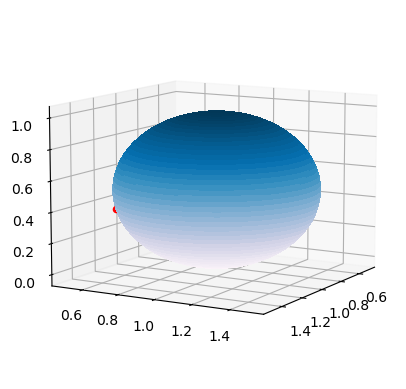

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x = 1 - 0.5 * np.outer(np.cos(u), np.sin(v))
y = 1 - 0.5 * np.outer(np.sin(u), np.sin(v))
z = 0.5 - 0.5 * np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(x, y, z, cmap='PuBu', linewidth=0, antialiased=False)
ax.scatter(ix, iy, iz, color='red', linewidth=1)
ax.view_init(elev=10., azim=30)

# Reweighting $\mathcal{N}(0, 1)$ to $\mathcal{N}(\mu, 1)$ with one model for any $\mu$

We will now parametrize our network by giving it a $\mu$ value in addition to $X_i\sim\mathcal{N}(\mu, 1)$.

First we uniformly sample $\mu$ values in some range

In [9]:
n_data_points = 10**5
mu_min = -2
mu_max = 2
mu_values = np.random.uniform(mu_min, mu_max, n_data_points)

We then sample from normal distributions with this $\mu$ value

In [10]:
X0 = [(np.random.normal(0, 1), mu) for mu in mu_values] # Note the zero in normal(0, 1) 
X1 = [(np.random.normal(mu, 1), mu) for mu in mu_values]

Please note that the samples in X0 are not paired with $\mu=0$ as this would make the task trivial. 

Instead it is paired with the $\mu$ values uniformly sampled in the specified range [mu_min, mu_max].

For every value of $\mu$ in mu_values, the network sees one event drawn from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,1)$, and it learns to classify them. 

I.e. we have one network that's parametrized by $\mu$ that classifies between events from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,1)$, and a trained network will give us the likelihood ratio to reweight from one to another. 

In [11]:
Y0 = to_categorical(np.zeros(n_data_points), num_classes=2)
Y1 = to_categorical(np.ones(n_data_points), num_classes=2)

X = np.concatenate((X0, X1))
Y = np.concatenate((Y0, Y1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Build Model

In [12]:
inputs = Input((2,))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr_model = Model(inputs = inputs, outputs = outputs)
dctr_model.compile(loss='categorical_crossentropy', optimizer='Adam')

## Train DCTR model

In [13]:
earlystopping = EarlyStopping(patience = 10,
                              restore_best_weights=True)
dctr_model.fit(X_train, Y_train, 
          epochs=200, 
          batch_size = 10000,
          validation_data = (X_test, Y_test),
          callbacks = [earlystopping])

Train on 160000 samples, validate on 40000 samples
Epoch 1/200
160000/160000 [==============================] - 0s 2us/sample - loss: 0.6467 - val_loss: 0.6095
Epoch 2/200
160000/160000 [==============================] - 0s 1us/sample - loss: 0.5881 - val_loss: 0.5738
Epoch 3/200
160000/160000 [==============================] - 0s 1us/sample - loss: 0.5705 - val_loss: 0.5703
Epoch 4/200
160000/160000 [==============================] - 0s 1us/sample - loss: 0.5680 - val_loss: 0.5686
Epoch 5/200
160000/160000 [==============================] - 0s 1us/sample - loss: 0.5667 - val_loss: 0.5679
Epoch 6/200
160000/160000 [==============================] - 0s 1us/sample - loss: 0.5657 - val_loss: 0.5674
Epoch 7/200
160000/160000 [==============================] - 0s 1us/sample - loss: 0.5650 - val_loss: 0.5666
Epoch 8/200
160000/160000 [==============================] - 0s 1us/sample - loss: 0.5640 - val_loss: 0.5652
Epoch 9/200
160000/160000 [==============================] - 0s 1us/sample - 

## Validate DCTR for any $\mu$

In [14]:
mu1 = -1.5
assert mu1>=mu_min and mu1<=mu_max # choose mu1 in valid range

X0_val = np.random.normal(0, 1, n_data_points)
X1_val = np.random.normal(mu1, 1, n_data_points)

In [15]:
X_input = np.array([(x, mu1) for x in X0_val])

In [16]:
preds = dctr_model.predict(X_input)
weights = preds[:,1]/preds[:,0]

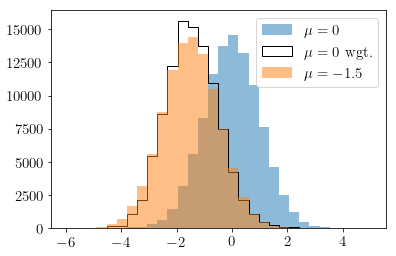

In [17]:
bins = np.linspace(-6,5,31)
plt.hist(X0_val, bins = bins, alpha = 0.5, label = r'$\mu=0$')
plt.hist(X0_val, bins = bins, label = r'$\mu=0$ wgt.', weights=weights, histtype='step', color='k')
plt.hist(X1_val, bins = bins, alpha = 0.5, label = r'$\mu={}$'.format(mu1))
plt.legend()
plt.show()

# Infer $\mu$ from unknown dataset ~ $\mathcal{N}(?, 1)$

## Build "mystery" dataset

In [18]:
mu_secret = 1.3
X_mystery = np.random.normal(mu_secret, 1, n_data_points)

In [19]:
Y0 = to_categorical(np.zeros(n_data_points), num_classes=2)
Y1 = to_categorical(np.ones(n_data_points), num_classes=2)

X = np.concatenate((np.array(X0)[:,0], X_mystery))
Y = np.concatenate((Y0, Y1))

## Build DCTR fit model

In [20]:
class AddParams2Input(Layer):
    """ Custom layer for tuning with DCTR: 
    Arguments:
    - n_MC_params : (int) - the number of n_MC_params that are in X_dim
    - default_MC_params : (list of floats) - default values for each of the MC parameters
    - trainable_MC_params : (list of booleans) - True for parameters that you want to fit, false for parameters that should be fixed at default value

    Usage: 
    Let X_dim be the input dimension of each particle to a PFN model, and n_MC_params be the number of MC parameters. 
    Defines a Layer that takes in an array of dimension 
    (batch_size, padded_multiplicity, X_dim - n_MC_params)
    This layer appends each particle by the default_MC_params and makes then trainable or non-trainable based on trainable_MC_params
    """
    
    def __init__(self, param):
        super(AddParams2Input, self).__init__()
        # Definitions
        self.param = param
    
    def build(self, input_shape):
        # Convert input parameter to a weight and make it trainable
        self.param = self.add_weight(name='param', 
                                     shape=(1, 1),
                                     initializer=Constant(self.param),
                                     trainable=True)
            
        super(AddParams2Input, self).build(input_shape)
    
    def call(self, input):
        return concatenate([input, self.param*tf.ones_like(input)], -1)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]+1)

In [21]:
mu_fit_init = 0

myinputs = Input(shape=(1,), name='input')
concat_input = AddParams2Input(mu_fit_init)(myinputs) 

for layer in dctr_model.layers:
    layer.trainable = False
        
# get the graph and the weights from the DCTR_model
output = dctr_model(inputs = concat_input)

dctr_fit_model = Model(inputs = myinputs, outputs = output)

dctr_fit_model.compile(loss='categorical_crossentropy', optimizer='Adam')

In [22]:
dctr_fit_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1)]               0         
_________________________________________________________________
add_params2input (AddParams2 (None, 2)                 1         
_________________________________________________________________
model_1 (Model)              (None, 2)                 5352      
Total params: 5,353
Trainable params: 1
Non-trainable params: 5,352
_________________________________________________________________


In [23]:
def set_param(dctr_fit_model, param):
    weights = [np.array([[param]],   dtype=np.float32)]
    dctr_fit_model.layers[1].set_weights(weights)

In [24]:
def get_loss(X, Y, dctr_fit_model, MC_params, batch_size = 1000):
    set_param(dctr_fit_model, MC_params)
    return dctr_fit_model.evaluate(x=X, y = Y, batch_size=batch_size)

## Loss as a funciton of $\mu$

We can evaluate the loss as a funciton of $\mu$ to show that it has a minimum arond `mu_secret`

In [25]:
loss = np.array([(mu, get_loss(X, Y, dctr_fit_model, mu)) for mu in np.linspace(0,2, 31)])


200000/200000 [==============================] - 0s 1us/sample - loss: 0.5678


W1026 14:33:56.502396 4560479680 legend.py:1285] No handles with labels found to put in legend.


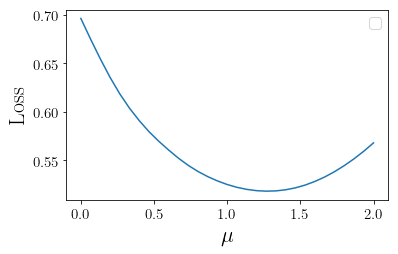

In [26]:
plt.plot(*loss.T)
plt.ylabel('Loss')
plt.xlabel(r'$\mu$')
plt.legend()
plt.tight_layout()
plt.show()

## Find mu_secret by gradient descent

In [27]:
set_param(dctr_fit_model, 0) # set mu back to default value

In [28]:
print_fit_value = LambdaCallback(on_epoch_end=lambda batch, logs: print("\n mu fit = ", 
                                               dctr_fit_model.get_weights()[0][0][0]))
fit_vals = [mu_fit_init]
append_fit_value = LambdaCallback(on_epoch_end=lambda batch, logs: 
                                               fit_vals.append(dctr_fit_model.get_weights()[0][0][0]))

callbacks = [print_fit_value, append_fit_value]

In [29]:
dctr_fit_model.fit(X, Y, 
                   epochs=100, 
                   batch_size = 1000, 
                   callbacks=callbacks)

Train on 200000 samples
Epoch 1/100
167000/200000 [========================>.....] - ETA: 0s - loss: 0.6705
 mu fit =  0.19391052
200000/200000 [==============================] - 0s 2us/sample - loss: 0.6657
Epoch 2/100
171000/200000 [========================>.....] - ETA: 0s - loss: 0.6186
 mu fit =  0.3586035
200000/200000 [==============================] - 0s 1us/sample - loss: 0.6160
Epoch 3/100
171000/200000 [========================>.....] - ETA: 0s - loss: 0.5874
 mu fit =  0.497295
200000/200000 [==============================] - 0s 1us/sample - loss: 0.5858
Epoch 4/100
162000/200000 [=======================>......] - ETA: 0s - loss: 0.5678
 mu fit =  0.6216057
200000/200000 [==============================] - 0s 1us/sample - loss: 0.5659
Epoch 5/100
166000/200000 [=======================>......] - ETA: 0s - loss: 0.5519
 mu fit =  0.74014795
200000/200000 [==============================] - 0s 1us/sample - loss: 0.5504
Epoch 6/100
170000/200000 [========================>.....] -

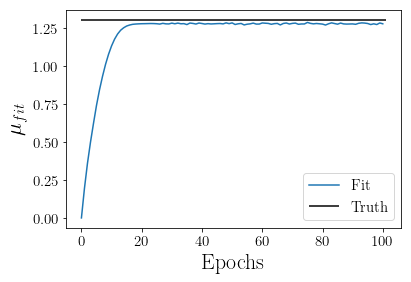

In [30]:
plt.plot(fit_vals, label='Fit')
plt.hlines(mu_secret, 0, len(fit_vals), label = 'Truth')
plt.xlabel("Epochs")
plt.ylabel(r'$\mu_{fit}$')
plt.legend()
plt.show()